# Regression on one Set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor

from micropyome.utils import log
from micropyome.taxa import regression
from micropyome.datasets import normalize

log.silence()

## Bacteria

In [2]:
DATASET_PATH = "data/averill_processed/bacteria/"

In [3]:
X = {}
Y = {}
for level in regression.TAXONOMIC_LEVELS:
    x = pd.read_csv(f"{DATASET_PATH}{level}/15_variables.csv")
    if level == 'fg':
        y = pd.read_csv(f"{DATASET_PATH}{level}/observed.csv")
    else:
        y = pd.read_csv(f"{DATASET_PATH}{level}/y_11groupTaxo.csv")

    x = x.drop(x.columns[0], axis=1)
    #x = normalize(x)
    scaler = StandardScaler()
    x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)


    y = y.drop(y.columns[0], axis=1)

    X[level] = x
    Y[level] = y

In [4]:
Y2 = {}  # Averill et al. results.
Y_RAW = {}
for level in regression.TAXONOMIC_LEVELS:
    y2 = pd.read_csv(f"{DATASET_PATH}{level}/predicted.csv")
    y = pd.read_csv(f"{DATASET_PATH}{level}/observed.csv")
    y_samples = y[y.columns[0]].to_list()
    y2_samples = y2[y2.columns[0]].to_list()
    for sample in y2[y2.columns[0]]:
        if not sample in y_samples:
            print(sample)
            y2.drop(sample)
    y2 = y2.drop(y2.columns[0], axis=1)
    y = y.drop(y.columns[0], axis=1)
    Y2[level] = y2
    Y_RAW[level] = y


raw_published_results = []
for level in regression.TAXONOMIC_LEVELS:
    r = regression.r2_score_by_column(Y_RAW[level], Y2[level])
    raw_published_results.append(np.mean(r))

published_results = []
for level in regression.TAXONOMIC_LEVELS:
    y, y2 = Y_RAW[level], Y2[level]
    for column in y.columns:
        if y[column].mean() < 0.003:
            y = y.drop(columns=[column])
            y2 = y2.drop(columns=[column])
    r = regression.r2_score_by_column(y, y2)
    published_results.append(np.mean(r))

print("Raw published results: ", raw_published_results)
print("Published results: ", published_results)


def graph_results(models: dict, results: dict):
    x = list(range(len(regression.TAXONOMIC_LEVELS)))

    for model in models:
        y = [results[level][model] for level in regression.TAXONOMIC_LEVELS]
        print(f"{model}: {y}")
        plt.plot(x, y, "-o", label=model)

    plt.plot(x, published_results, "-o", label="Averill, filtered")
    plt.plot(x, raw_published_results, "-o", label="Averill, raw")

    plt.xticks(x, regression.TAXONOMIC_LEVELS)
    plt.legend()
    plt.show()

Raw published results:  [0.6143865412012766, 0.4939120573376682, 0.3947728965535883, 0.44519862920621506, 0.3528865773869716, -0.12356104631217138]
Published results:  [0.6694304599634192, 0.4939120573376682, 0.3947728965535883, 0.44519862920621506, 0.3528865773869716, 0.2349787872136751]


### Logit

C:\Users\vince\AppData\Local\Temp\ipykernel_19912\1978579436.py:5: RuntimeWarning: invalid value encountered in log
  y = np.log(p / (1 - p))


Logit: [0.1670620308025872, 0.24210095862427974, 0.19349488568768913, 0.16744479954486505, 0.07669521720155312, -0.04292343810349041]
Linear: [0.22784800495424345, 0.36766341004605624, 0.28615493290288074, 0.3223790320345671, 0.2519287290486301, 0.18620453908534546]
DT: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


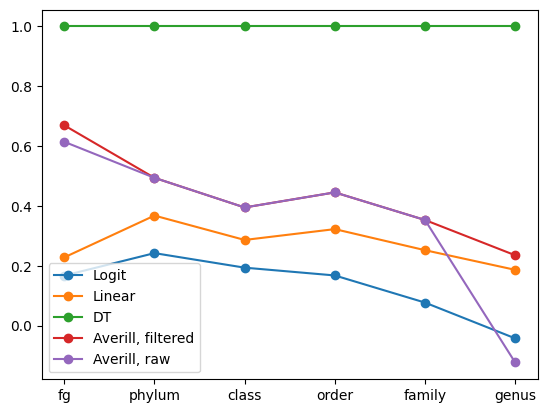

C:\Users\vince\AppData\Local\Temp\ipykernel_19912\1978579436.py:5: RuntimeWarning: invalid value encountered in log
  y = np.log(p / (1 - p))


Logit: [0.21300637425995456, 0.24210095862427974, 0.19349488568768913, 0.16744479954486505, 0.07669521720155312, -0.029037402612960242]
Linear: [0.25363810070224063, 0.36766341004605624, 0.28615493290288074, 0.3223790320345671, 0.2519287290486301, 0.16917212859272218]
DT: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


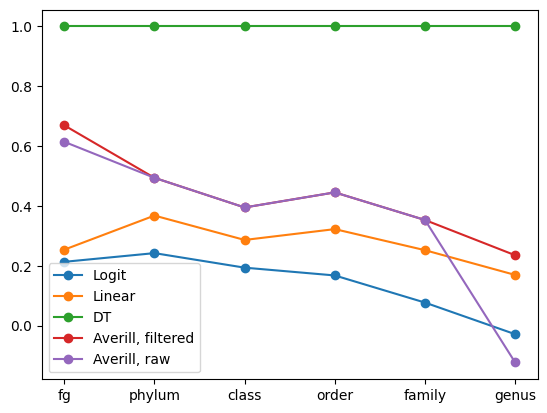

In [5]:
class LogitRegression(LinearRegression):

    def fit(self, x, p):
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        y = np.nan_to_num(y, nan=0)
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x)
        return 1 / (np.exp(-y) + 1)


models = {
    "Logit": LogitRegression(),
    "Linear": LinearRegression(),
    "DT": DecisionTreeRegressor()
}
results = regression.multiple_taxa(models, X, Y)
graph_results(models, results)
results = regression.multiple_taxa(models, X, Y, threshold=0.003)
graph_results(models, results)